# Purpose
Demonstrate using FCN for inference as outlined in README.md

Scripts ported from [Mask-RCNN](../../mask-rcnn/dependencies/inference.ipynb) and [DUC inference](../../duc/dependencies/duc-inference.ipynb) as the output structure is very similar.

## Step 1: Preprocess the image

In [1]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms, models

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
input_image = Image.open("000000025205.jpg")
orig_tensor = np.asarray(input_image)
input_tensor = preprocess(input_image)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.detach().cpu().numpy()

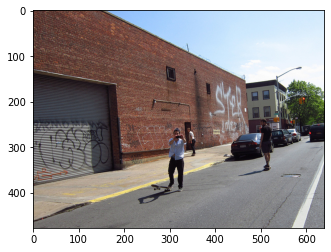

In [12]:
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(orig_tensor)

## Step 2: Run inference

In [13]:
from onnx import numpy_helper
import os
import onnxruntime as rt

# Start from ORT 1.10, ORT requires explicitly setting the providers parameter if you want to use execution providers
# other than the default CPU provider (as opposed to the previous behavior of providers getting set/registered by default
# based on the build flags) when instantiating InferenceSession.
# Following code assumes NVIDIA GPU is available, you can specify other execution providers or don't include providers parameter
# to use default CPU provider.
sess = rt.InferenceSession("../model/fcn-resnet101-11.onnx", providers=['CUDAExecutionProvider'])

outputs = sess.get_outputs()
output_names = list(map(lambda output: output.name, outputs))
input_name = sess.get_inputs()[0].name

detections = sess.run(output_names, {input_name: input_tensor})
print("Output shape:", list(map(lambda detection: detection.shape, detections)))
output, aux = detections

Output shape: [(1, 21, 478, 640), (1, 21, 478, 640)]


## Step 3: Postprocess, display output

`get_palette()` : Returns predefined color palette for generating output segmentation map

`colorize()` : Generate the segmentation map using output `labels` generated by the model and color palette from `get_palette()`

`predict()` : Performs forward pass on the model using the preprocessed input, generates colorized segmentation map using `colorize()`

In [14]:
from matplotlib.colors import hsv_to_rgb
import cv2

classes = [line.rstrip('\n') for line in open('voc_classes.txt')]
num_classes = len(classes)

def get_palette():
    # prepare and return palette
    palette = [0] * num_classes * 3
    
    for hue in range(num_classes):
        if hue == 0: # Background color
            colors = (0, 0, 0)
        else:
            colors = hsv_to_rgb((hue / num_classes, 0.75, 0.75))
            
        for i in range(3):
            palette[hue * 3 + i] = int(colors[i] * 255)
            
    return palette

def colorize(labels):
    # generate colorized image from output labels and color palette
    result_img = Image.fromarray(labels).convert('P', colors=num_classes)
    result_img.putpalette(get_palette())
    return np.array(result_img.convert('RGB'))

def visualize_output(image, output):
    assert(image.shape[0] == output.shape[1] and \
           image.shape[1] == output.shape[2]) # Same height and width
    assert(output.shape[0] == num_classes)
    
    # get classification labels
    raw_labels = np.argmax(output, axis=0).astype(np.uint8)

    # comput confidence score
    confidence = float(np.max(output, axis=0).mean())

    # generate segmented image
    result_img = colorize(raw_labels)
    
    # generate blended image
    blended_img = cv2.addWeighted(image[:, :, ::-1], 0.5, result_img, 0.5, 0)
    
    result_img = Image.fromarray(result_img)
    blended_img = Image.fromarray(blended_img)

    return confidence, result_img, blended_img, raw_labels

conf, result_img, blended_img, _ = visualize_output(orig_tensor, output[0])

12.307448387145996


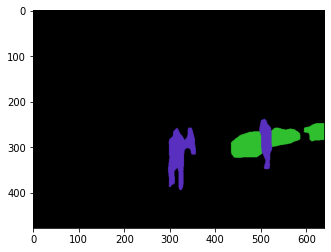

In [15]:
%matplotlib inline
print(conf)
imshow(np.asarray(result_img))

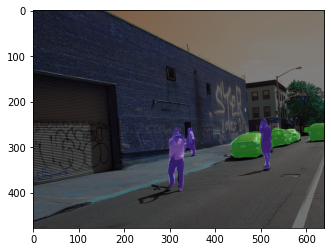

In [16]:
imshow(np.asarray(blended_img))

In [17]:
aux_conf, aux_result, aux_blended, _ = visualize_output(orig_tensor, aux[0])

11.28640365600586


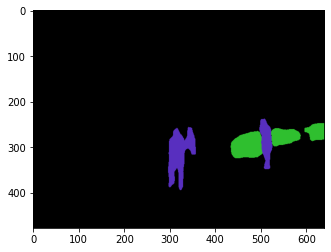

In [18]:
print(aux_conf)
imshow(np.asarray(aux_result))

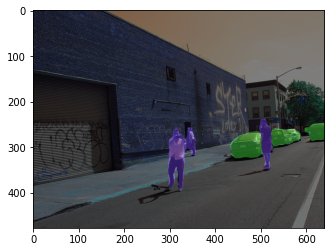

In [19]:
imshow(np.asarray(aux_blended))